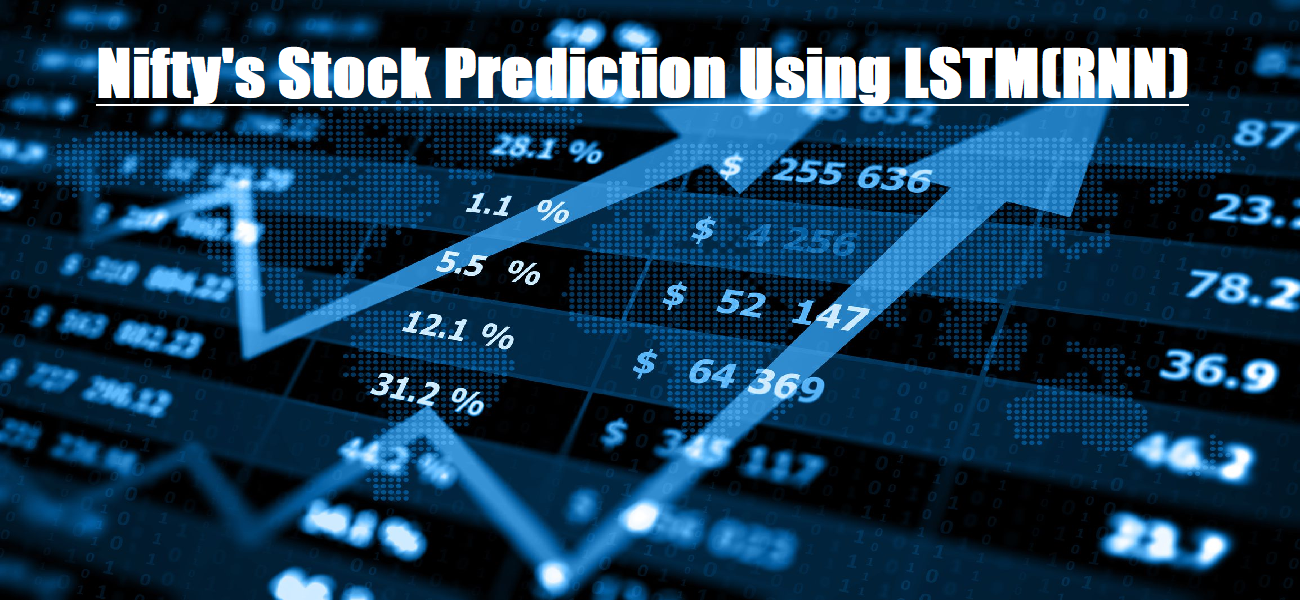

### Import Live Nifty stock data

In [91]:
import pandas as pd
import numpy as np
#!pip install yfinance
import yfinance as yf
import datetime
from datetime import date, timedelta
today=date.today()
today

datetime.date(2023, 2, 20)

In [92]:
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=720)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

df = yf.download('INFY', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-02,17.920000,18.090000,17.790001,18.020000,17.295637,10306600
2021-03-03,18.410000,18.610001,18.110001,18.459999,17.717947,22911800
2021-03-04,18.290001,18.680000,18.010000,18.170000,17.439606,11867600
2021-03-05,18.250000,18.299999,17.840000,18.280001,17.545185,8946500
2021-03-08,18.290001,18.410000,17.980000,17.980000,17.257242,8450900


In [93]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-13,18.889999,19.049999,18.860001,19.020000,19.020000,5610000
2023-02-14,19.059999,19.240000,18.950001,19.120001,19.120001,6225500
2023-02-15,19.120001,19.270000,19.080000,19.230000,19.230000,8592700
2023-02-16,19.110001,19.290001,19.070000,19.120001,19.120001,6542000
2023-02-17,19.010000,19.120001,18.950001,19.080000,19.080000,5695200


In [94]:
df.shape

(497, 6)

In [95]:
df.size

2982

In [96]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [97]:
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 497 entries, 2021-03-02 to 2023-02-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       497 non-null    float64
 1   High       497 non-null    float64
 2   Low        497 non-null    float64
 3   Close      497 non-null    float64
 4   Adj Close  497 non-null    float64
 5   Volume     497 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.2 KB


In [99]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,497.000000,497.000000,497.000000,497.000000,497.000000,4.970000e+02
mean,20.586177,20.763119,20.417827,20.597243,20.174904,8.390180e+06
std,2.353976,2.367646,2.329846,2.348385,2.235671,4.479901e+06
min,16.580000,16.709999,16.389999,16.610001,16.431274,2.151400e+06
25%,18.600000,18.750000,18.389999,18.620001,18.294325,5.313100e+06
50%,19.840000,20.020000,19.709999,19.760000,19.580582,7.337900e+06
75%,22.809999,22.969999,22.570000,22.780001,22.208782,1.021400e+07
max,26.150000,26.389999,25.580000,26.200001,25.631622,4.268660e+07


In [100]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Plotting the Nifty stocks

In [101]:
data=df.reset_index()
data=data[['Date','Close']]

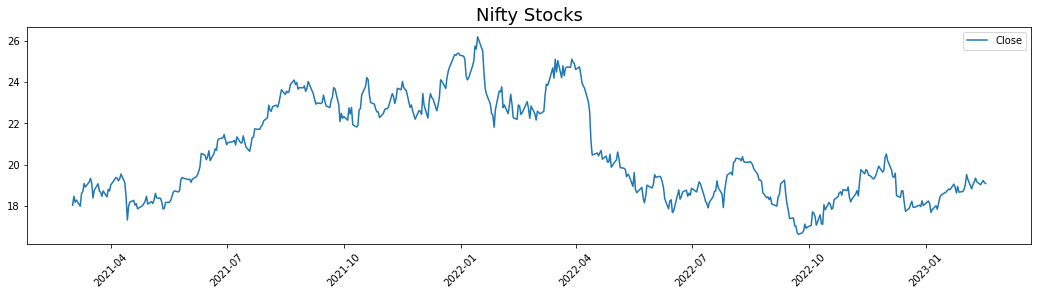

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,4))
plt.plot(data.set_index('Date'), label='Close')
plt.xticks(rotation=45)
plt.legend()
plt.title('Nifty Stocks', fontsize=18);

### Preparing the data
- The LSTM model will need data input in the form of X Vs y. Where the X will represent the last N day’s(10) prices and y will represent the N+1th day (11th-day) price.
- By looking at a lot of such examples from the past 2 years, the LSTM will be able to learn the movement of prices. Hence, when we pass the last 10 days of the price it will be able to predict tomorrow’s stock close price.
- Since LSTM is a Neural network-based algorithm, standardizing or normalizing the data is mandatory for a fast and more accurate fit.

#### Extracting the closing prices of each day

In [103]:
close=data[['Close']].values
close[:5]

array([[18.02000046],
       [18.45999908],
       [18.17000008],
       [18.28000069],
       [17.97999954]])

#### Feature scaling for fast training of neural network

In [104]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scaler=scaler.fit(close)
X=scaler.transform(close)
X[:5]

array([[0.14702814],
       [0.19290912],
       [0.16266939],
       [0.17413973],
       [0.14285703]])

### Preparing Data for LSTM

#### Split into Samples X and Y(Input X output Y)

In [105]:
x=[]
y=[]
no_of_rows=len(X)

# next day's Price Prediction is based on last how many past day's prices
time_step=10

# iterate through values to create combination
for i in range(time_step, no_of_rows, 1):
    x0=X[i-time_step:i]
    y0=X[i]
    x.append(x0)
    y.append(y0)

# reshape the input to a 3D (no_of_sample, time_step, features)
x_data=np.array(x)
x_data=x_data.reshape(x_data.shape[0], x_data.shape[1], 1)
print("x data shape :", x_data.shape)

# reshape the output to 2D as it is supposed to single column
y_data=np.array(y)
y_data=y_data.reshape(y_data.shape[0],1)
print("y data shape: ", y_data.shape)

x data shape : (487, 10, 1)
y data shape:  (487, 1)


#### Split the data into train and test
- Keeping last few days of data to test the learnings of the model and rest for training the model.
- Here I am choosing Last 10 days as testing

In [106]:
# choose number of testing data rows
test_rows=10

# split data into train & test
x_train=x_data[: - test_rows]
x_test=x_data[- test_rows:]
y_train=y_data[: - test_rows]
y_test=y_data[- test_rows:]
print("x train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y test shape: ", y_test.shape)

x train shape:  (477, 10, 1)
y_train shape:  (477, 1)
x_test shape:  (10, 10, 1)
y test shape:  (10, 1)


### Creating the Deep Learning LSTM model
- Look at the use of the LSTM function instead of Dense to define the hidden
layers.
- The output layer has one neuron as we are predicting the next day price.
- If you want to predict for multiple days, then change the input data and neurons equal to the number of days of forecast.

In [107]:
# Defining Input shapes for LSTM
time_step=x_train.shape[1]
tot_feature=x_train.shape[2]
print("Number of TimeSteps:", time_step)
print("Number of Features:", tot_feature)

Number of TimeSteps: 10
Number of Features: 1


- In the below code snippet I have used three hidden LSTM layers and one output layer. You can choose more layers if you don’t get accuracy for your data. Similarly you can increase or decrease the number of neurons in the hidden layer.
- Just keep in mind, the more neurons and layers you use, the slower the model becomes. Because now there are many more computations to be done.

#### Each layer has some hyperparameters which needs to be tuned. some of the important hyperparameters of LSTM below, 
- **units=10**: This means we are creating a layer with ten neurons in it. Each of these five neurons will be receiving the values of inputs.
- **input_shape = (TimeSteps, TotalFeatures)**: The input expected by LSTM is in 3D format. Our training data has a shape of (420, 10, 1) this is in the form of (number of samples, time steps, number of features). This means we have 420 examples to learn in training data, each example looks back 10-steps in time like what was the stock price yesterday, the day before yesterday so on till last 10 days. This is known as Time steps. The last number ‘1’ represents the number of features. Here we are using just one column ‘Closing Stock Price’ hence its equal to ‘1’
- **kernel_initializer=’uniform’**: When the Neurons start their computation, some algorithm has to decide the value for each weight. This parameter specifies that. You can choose different values for it like **‘normal’** or **‘glorot_uniform’**.
- **activation=’relu’**: This specifies the activation function for the calculations inside each neuron. You can choose values like **‘relu’, ‘tanh’, ‘sigmoid’,** etc.
- **return_sequences=True**: LSTMs backpropagate thru time, hence they return the values of the output from each time step to the next hidden layer. This keeps the expected input of the next hidden layer in the 3D format. This parameter is False for the last hidden layer because now it does not have to return a 3D output to the final Dense layer.
- **optimizer=’adam’**: This parameter helps to find the optimum values of each weight in the neural network. **‘adam’** is one of the most useful optimizers, another one is **‘rmsprop’**.
- **batch_size=10**: This specifies how many rows will be passed to the Network in one go after which the SSE calculation will begin and the neural network will start adjusting its weights based on the errors. When all the rows are passed in the batches of 10 rows each as specified in this parameter, then we call that **1-epoch**. Or **one full data cycle**. This is also known as **mini-batch gradient descent**. A small value of batch_size will make the LSTM look at the data slowly, like 2 rows at a time or 4 rows at a time which could lead to overfitting, as compared to a large value like 20 or 50 rows at a time, which will make the LSTM look at the data fast which could lead to underfitting. Hence a proper value must be chosen using hyperparameter tuning.
- **Epochs=10**: The same activity of adjusting weights continues for 10 times, as specified by this parameter. In simple terms, the LSTM looks at the full training data 10 times and adjusts its weights.

In [108]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [109]:
# Initialising the RNN
model = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer.
model.add(LSTM(units = 10, activation = 'relu', input_shape = (time_step, tot_feature), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
model.add(LSTM(units = 5, activation = 'relu', input_shape = (time_step, tot_feature), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
model.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
model.add(Dense(units = 1))
 
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [110]:
import time
# Measuring the time taken by the model to train
start_time=time.time()
 
# Fitting the RNN to the Training set
model.fit(x_train, y_train, batch_size = 5, epochs = 100)
 
end_time=time.time()
print("Total Time Taken: ", round((end_time-start_time)/60), 'Minutes')

Epoch 1/100
96/96 [==============================] - 21s 11ms/step - loss: 0.1341
Epoch 2/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0142
Epoch 3/100
96/96 [==============================] - 1s 12ms/step - loss: 0.0106
Epoch 4/100
96/96 [==============================] - 2s 17ms/step - loss: 0.0095
Epoch 5/100
96/96 [==============================] - 1s 15ms/step - loss: 0.0089
Epoch 6/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0086
Epoch 7/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0079
Epoch 8/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0078
Epoch 9/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0077
Epoch 10/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0081
Epoch 11/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0074
Epoch 12/100
96/96 [==============================] - 1s 11ms/step - loss: 0.0075
Epoch 13/100
96/96 [====

### Making Predictions and Measuring the accuracy of the model on testing data
- Now using the trained model, we are checking if the predicted prices for the last 10 days are close to the actual prices or not.
- Notice the inverse transform of the predictions. Since we normalized the data before the model training, the predictions on testing data will also be normalized, hence the inverse transformation will bring the values to the original scale. Then only we must calculate the percentage accuracy.

In [111]:

# Making predictions on test data
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)
 
# Getting the original price values for testing data
act=y_test
act=scaler.inverse_transform(y_test)
 
# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(act-pred)/act)).mean())

1/1 [==============================] - 0s 400ms/step
Accuracy: 99.13772333842296


**Accuracy is 99.137%.**

### Visualising the results

In [112]:
data.head()

,Date,Close
0,2021-03-02,18.020000
1,2021-03-03,18.459999
2,2021-03-04,18.170000
3,2021-03-05,18.280001
4,2021-03-08,17.980000


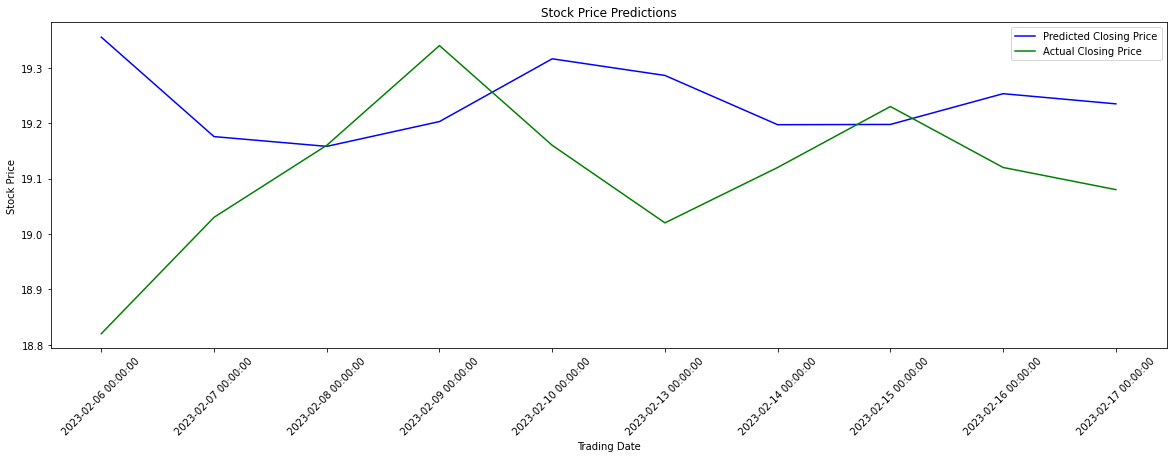

In [113]:
plt.plot(pred, color = 'blue', label = 'Predicted Closing Price')
plt.plot(act, color = 'green', label = 'Actual Closing Price')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(test_rows), data.tail(test_rows)['Date'], rotation=45)
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

### Visualizing the predictions for full data
- Plotting the training and testing data both to see how good the LSTM model has fitted.

1/1 [==============================] - 0s 34ms/step


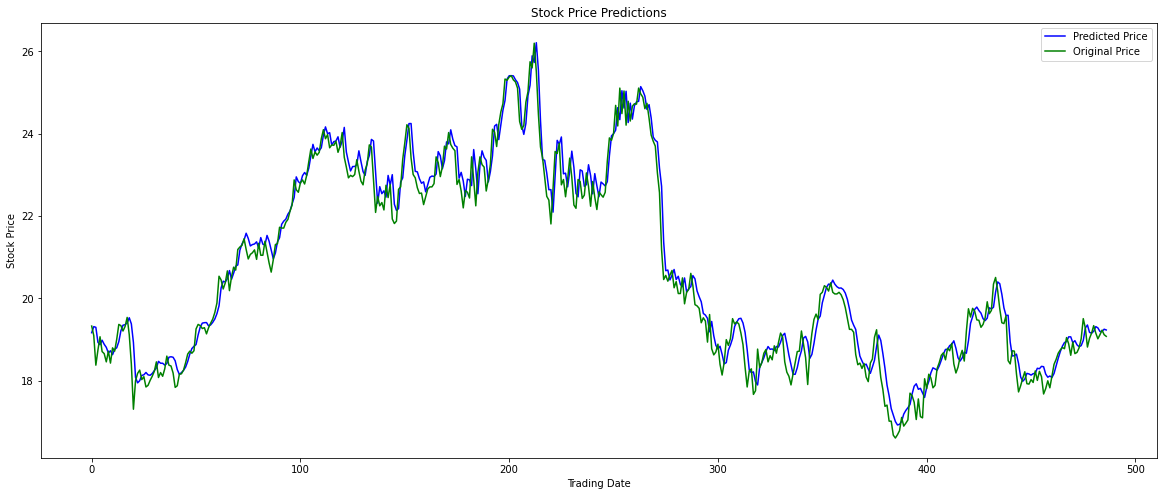

In [120]:
# Generating predictions on full data
TrainPredictions=scaler.inverse_transform(model.predict(x_train))
TestPredictions=scaler.inverse_transform(model.predict(x_test))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=close[time_step:]

 
# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'green', label = 'Original Price')
 
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

### Prediction for Tomorrow
- ou want to predict the price for tomorrow, all you have to do is to pass the last 10 day’s prices to the model in 3D format as it was used in the training.

In [121]:
# Last 10 days prices
Last10Days=np.array(close[-10:])
 
# Normalizing the data just like we did for training the model
Last10Days=scaler.transform(Last10Days.reshape(-1,1))
 
# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)
 
 
# Making predictions on data
predicted_Price = model.predict(Last10Days)
predicted_Price = scaler.inverse_transform(predicted_Price)
predicted_Price

1/1 [==============================] - 0s 28ms/step


array([[19.200888]], dtype=float32)

## Model to prediction for Next 15 days

In [122]:
# Considering the Full Data again which we extracted above
print(close[-10:])

[[18.81999969]
 [19.03000069]
 [19.15999985]
 [19.34000015]
 [19.15999985]
 [19.02000046]
 [19.12000084]
 [19.22999954]
 [19.12000084]
 [19.07999992]]


In [123]:
# Printing last 10 values of the scaled data which we have created above for the last model
# Here I am changing the shape of the data to one dimensional array because
# for Multi step data preparation we need to X input in this fashion
X=X.reshape(X.shape[0],)
print('Scaled Prices')
print(X[-10:])

Scaled Prices
[0.23044828 0.2523462  0.2659019  0.28467148 0.2659019  0.25130342
 0.26173099 0.27320114 0.26173099 0.25755988]


In [124]:
# Multi step data preparation
 
# split into input and output samples
x_data = []
y_data = []
 
no_of_rows = len(X)
# next few day's Price Prediction is based on last how many past day's prices
time_step=10
# How many days in future you want to predict the prices
future_time_step=15
 
# Iterate thru the values to create combinations
for i in range(time_step , no_of_rows - future_time_step , 1):
    x = X[i-time_step:i]
    y = X[i:i+future_time_step]
    x_data.append(x)
    y_data.append(y)
 
 
# Reshape the Input as a 3D (samples, Time Steps, Features)
x_data=np.array(x_data)
x_data=x_data.reshape(x_data.shape[0],x_data.shape[1], 1)
print("X data Shape: ", x_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_data)
print("y data shape: ", y_data.shape)

X data Shape:  (472, 10, 1)
y data shape:  (472, 15)


#### Splitting the data into Training and Testing

In [125]:
# Choosing the number of testing data records
test_rows=15
 
# Splitting the data into train and test
x_train=x_data[:-test_rows]
x_test=x_data[-test_rows:]
y_train=y_data[:-test_rows]
y_test=y_data[-test_rows:]
 
print("x train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y test shape: ", y_test.shape)

x train shape:  (457, 10, 1)
y_train shape:  (457, 15)
x_test shape:  (15, 10, 1)
y test shape:  (15, 15)


### Creating the Deep Learning Multi-Step LSTM model
- I am using the same configurations as used in the last model. The change is done at the Dense layer. Now the dense layer outputs the number of values equal to the future_time_step. Which is 15 in this case since we want to predict the next 15 days.
- You can change this to 10 to 20 if you want to predict for more days, but you need to prepare the data in the same manner before running this code.

In [126]:
# Defining Input shapes for LSTM
time_step=x_train.shape[1]
tot_feature=x_train.shape[2]
print("Number of Time Steps:", time_step)
print("Number of Features:", tot_feature)

Number of Time Steps: 10
Number of Features: 1


In [127]:
# Initialising the RNN
model = Sequential()

# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer.
model.add(LSTM(units = 10, activation = 'relu', input_shape = (time_step, tot_feature), return_sequences=True))
 
# Adding the Second Second hidden layer and the LSTM layer
model.add(LSTM(units = 5, activation = 'relu', input_shape = (time_step, tot_feature), return_sequences=True))
 
# Adding the Second Third hidden layer and the LSTM layer
model.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
# Notice the number of neurons in the dense layer is now the number of future time steps 
# Based on the number of future days we want to predic
model.add(Dense(units = future_time_step))
 
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [128]:
import time
# Measuring the time taken by the model to train
start_time=time.time()
 
# Fitting the RNN to the Training set
model.fit(x_train, y_train, batch_size = 5, epochs = 100)
 
end_time=time.time()
print("Total Time Taken: ", round((end_time-start_time)/60), 'Minutes')

Epoch 1/100
92/92 [==============================] - 5s 11ms/step - loss: 0.2137
Epoch 2/100
92/92 [==============================] - 1s 11ms/step - loss: 0.1572
Epoch 3/100
92/92 [==============================] - 1s 11ms/step - loss: 0.1187
Epoch 4/100
92/92 [==============================] - 1s 11ms/step - loss: 0.0941
Epoch 5/100
92/92 [==============================] - 1s 11ms/step - loss: 0.0790
Epoch 6/100
92/92 [==============================] - 1s 11ms/step - loss: 0.0703
Epoch 7/100
92/92 [==============================] - 1s 15ms/step - loss: 0.0658
Epoch 8/100
92/92 [==============================] - 2s 17ms/step - loss: 0.0635
Epoch 9/100
92/92 [==============================] - 1s 12ms/step - loss: 0.0625
Epoch 10/100
92/92 [==============================] - 1s 11ms/step - loss: 0.0621
Epoch 11/100
92/92 [==============================] - 1s 11ms/step - loss: 0.0618
Epoch 12/100
92/92 [==============================] - 1s 11ms/step - loss: 0.0618
Epoch 13/100
92/92 [=====

### Making Predictions and Measuring the accuracy of the model on testing data
- Since this is Multi step model trained to predict next 5 days. Each prediction will generate 5 days’ prices which we can match with the original prices.
- We will compare them one row at a time

In [129]:
# Making predictions on test data
pred = model.predict(x_test)
pred = scaler.inverse_transform(pred)
 
# Getting the original price values for testing data
act=y_test
act=scaler.inverse_transform(y_test)
 
# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(act-pred)/act)).mean())

1/1 [==============================] - 0s 384ms/step
Accuracy: 90.00636991257208


### Visualize the results

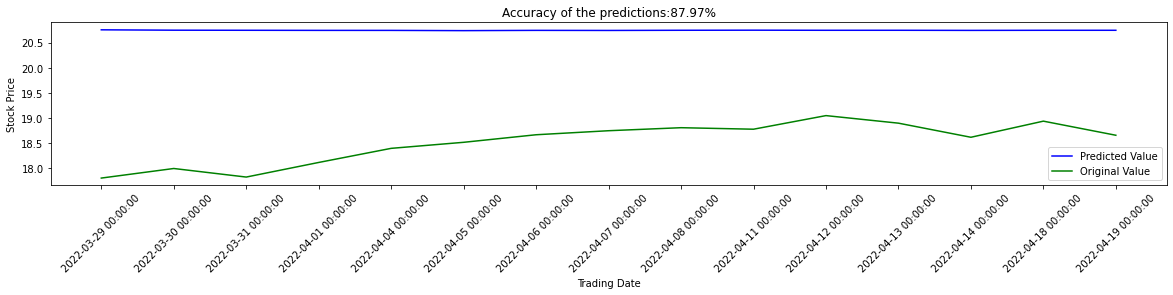

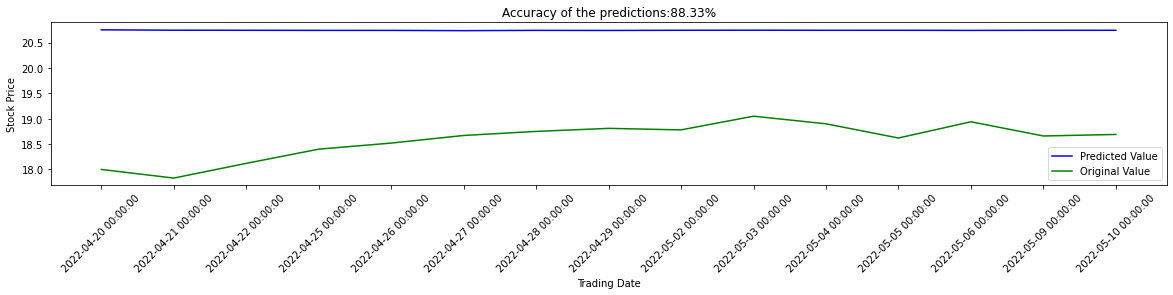

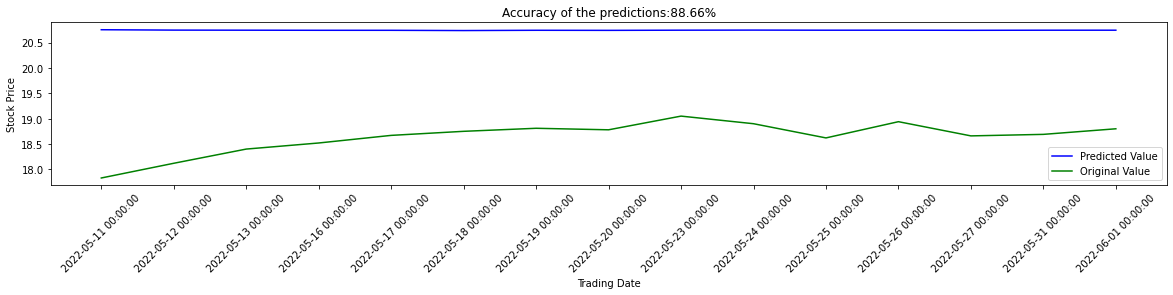

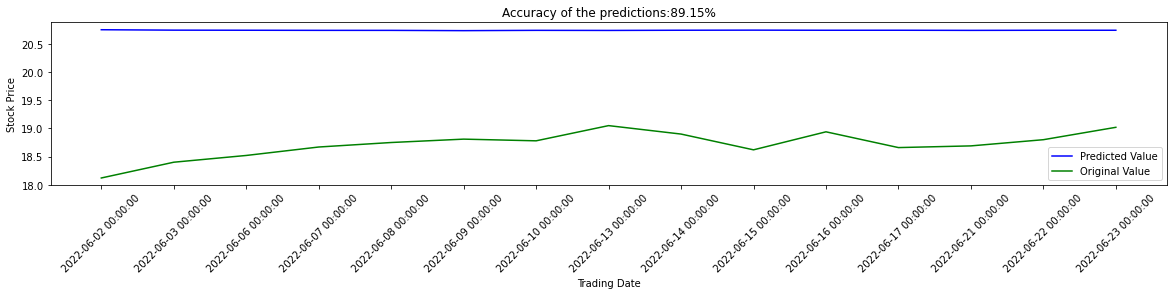

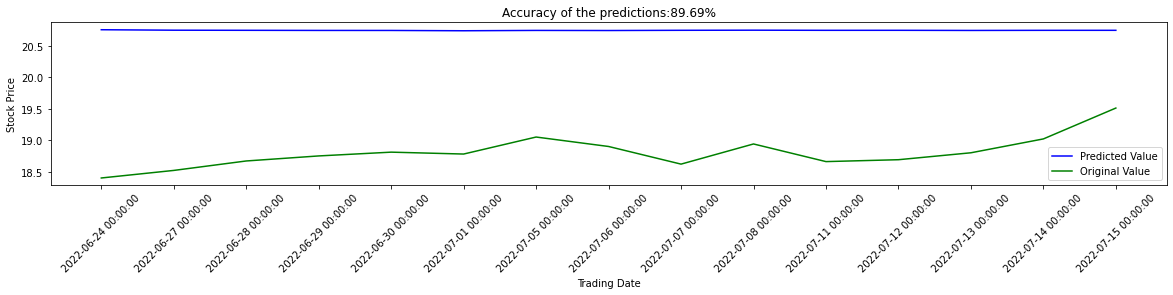

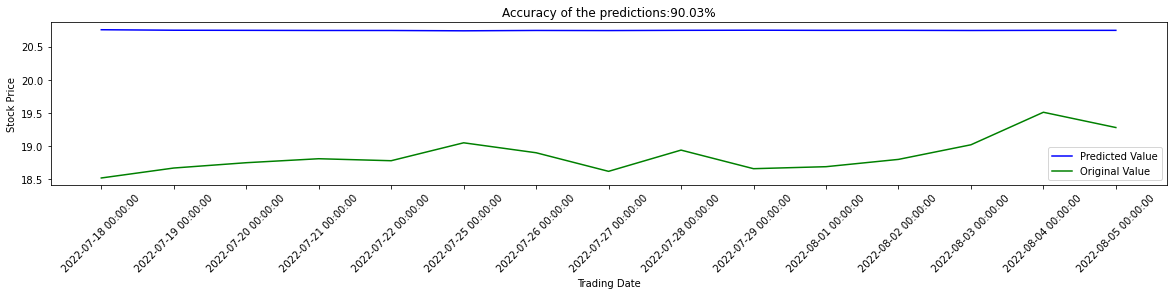

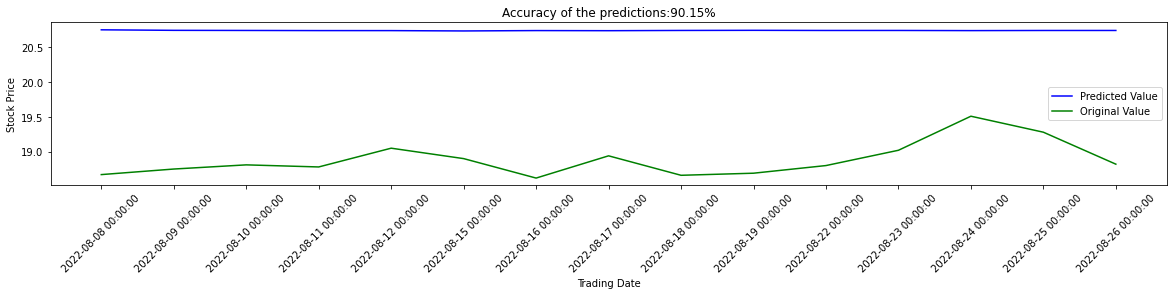

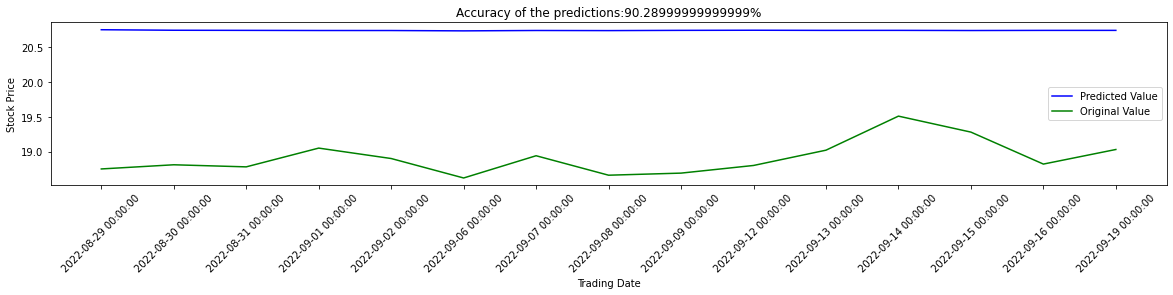

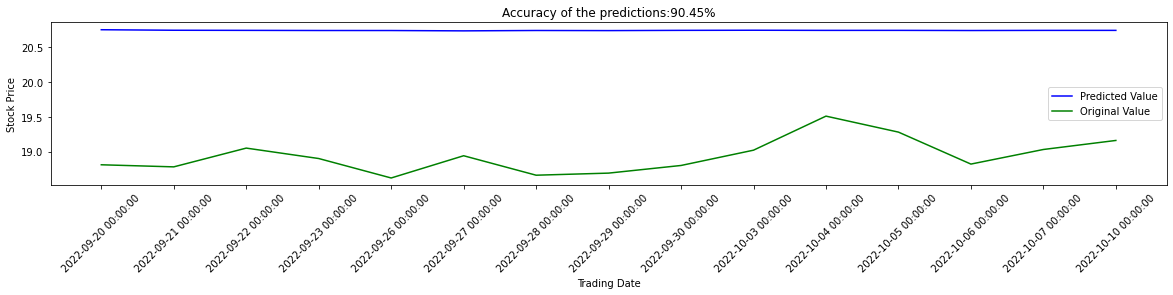

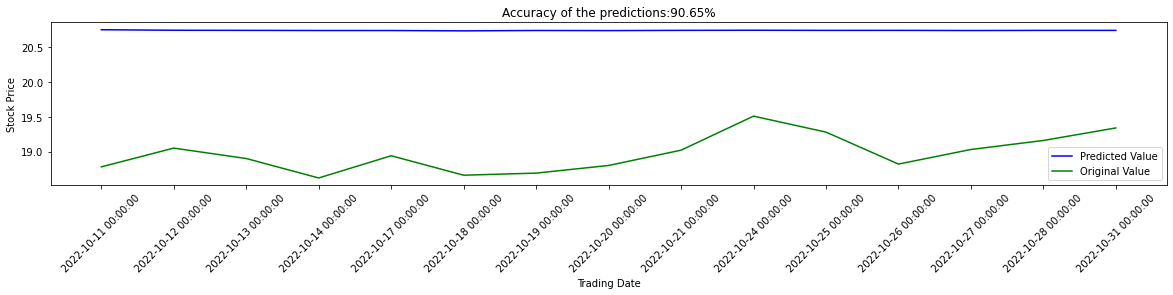

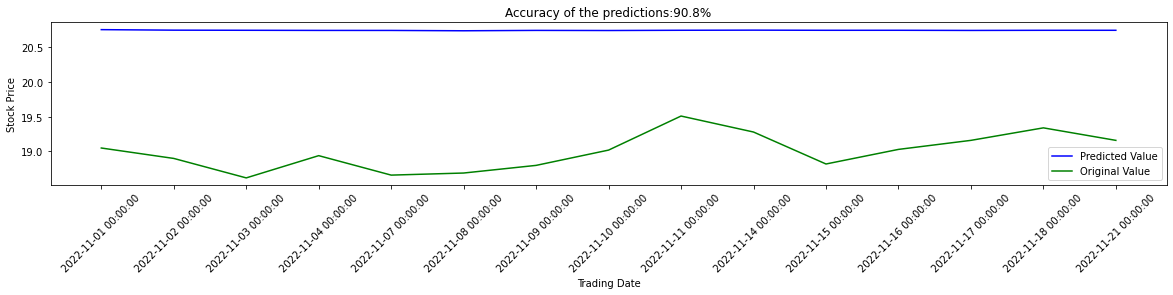

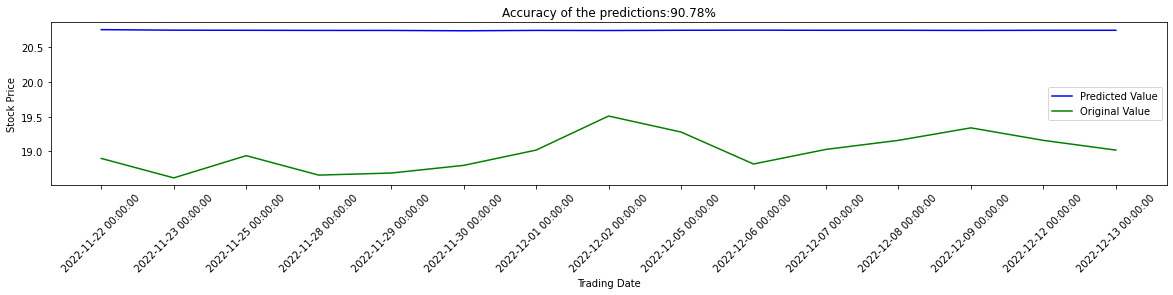

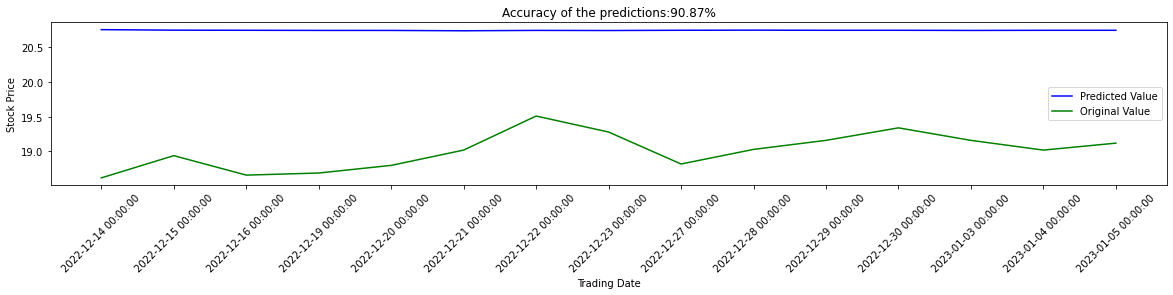

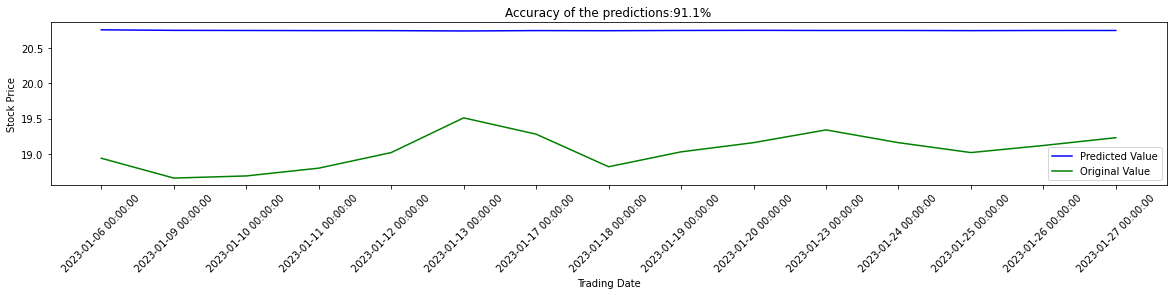

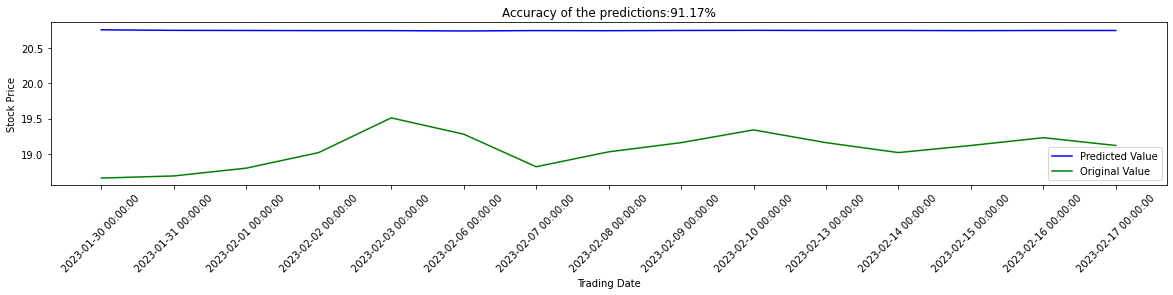

In [130]:
for i in range(len(act)):
    Prediction=pred[i]
    Original=act[i]
    
    # Visualising the results
    plt.plot(Prediction, color = 'blue', label = 'Predicted Value')
    plt.plot(Original, color = 'green', label = 'Original Value')
 
    plt.title('Accuracy of the predictions:'+ str(100 - (100*(abs(Original-Prediction)/Original)).mean().round(2))+'%')
    plt.xlabel('Trading Date')
    plt.xticks(rotation=45)
    
    startDateIndex=(future_time_step*test_rows)-future_time_step*(i+1)
    endDateIndex=(future_time_step*test_rows)-future_time_step*(i+1) + future_time_step
    dd=df.reset_index()
    TotalRows=dd.shape[0]

    plt.xticks(range(future_time_step), dd.iloc[TotalRows-endDateIndex : TotalRows-(startDateIndex) , :]['Date'])
    plt.ylabel('Stock Price')
 
    plt.legend()
    fig=plt.gcf()
    fig.set_figwidth(20)
    fig.set_figheight(3)
    plt.show()

### Making predictions for the next 15 days
If you want to predict the price for the next 15 days, all you have to do is to pass the last 10 day’s prices to the model in 3D format as it was used in the training.

In [131]:

# Making predictions on test data
Last10DaysPrices=np.array(close[-10:])
 
# Reshaping the data to (-1,1 )because its a single entry
Last10DaysPrices=Last10DaysPrices.reshape(-1, 1)
 
# Scaling the data on the same level on which model was trained
x_test=scaler.transform(Last10DaysPrices)
 
NumberofSamples=1
TimeSteps=x_test.shape[0]
NumberofFeatures=x_test.shape[1]
# Reshaping the data as 3D input
x_test=x_test.reshape(NumberofSamples,TimeSteps,NumberofFeatures)
 
# Generating the predictions for next 5 days
Next15DaysPrice = model.predict(x_test)
 
# Generating the prices in original scale
Next15DaysPrice = scaler.inverse_transform(Next15DaysPrice)
Next15DaysPrice

1/1 [==============================] - 0s 25ms/step


array([[20.75323 , 20.745667, 20.744   , 20.742117, 20.741785, 20.736895,
        20.742275, 20.740652, 20.744131, 20.74589 , 20.743822, 20.743992,
        20.741806, 20.743656, 20.743887]], dtype=float32)

### Conclusion
This prediction is only short-term. The moment you try to predict for multiple days like the next 30-days or 60 days, this fails miserably. Not because our LSTM model is bad, but, because Stock markets are highly volatile.